In [1]:
import sys
sys.path.append("/home/ricky/Documents/from_work/git/NMR_FF_tools/relaxation_times/")
sys.path.insert(1, '/home/ricky/Documents/from_work/git/charged_molecules_binding/simulations_list/')

sys.path.append("../")

import numpy as np
import relaxation_times as rt
import manage_files as mf
import plotting as pt
import matplotlib.pyplot as plt
import os
import re
import yaml
import gc
import math
import warnings

from scipy.optimize import minimize

import SRT_optimization as srt

import random
from datetime import date
today = date.today()

import fnmatch

gc.collect()

/home/ricky/anaconda3/envs/all3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ricky/anaconda3/envs/all3/lib/python3.8/site-packages/MDAnalysis/coordinates/chemfiles.py:59: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


0

<H3>Load the saved data</H3>
comes from 01_main_figure, in there data in more fields can be calculated and saved for the purposes of this part

In [9]:
magn_field_MHz=850 # for values in MHz
magnetic_field=magn_field_MHz*2*np.pi/gammaH*10**6
save_labels=["small_peptides",
       "peptides_SDSmicelles",
       "Calmodulin",
       "CDNF",
       "EN2",
       "musMANF",
       "TonB"]

# data is saved in the form [[effTimes],[R1],[R2],[hetNOE]]

systems={}
for system in save_labels:
    systems[system]=np.loadtxt("../01_main_figure/"+system+"_"+str(magn_field_MHz)+".dat")
    

# data is saved in the form [[effTimes,effTime[-1:0]],[R1limits_min,R1limits_max[-1:0]]]
# resp [[effTimes,effTime[-1:0]],[R2limits_min,R1limits_max[-1:0]]] - the data

limits={}
limits["R1"]=np.loadtxt("../01_main_figure/R1_limits_"+str(magn_field_MHz)+".dat")
limits["R2"]=np.loadtxt("../01_main_figure/R2_limits_"+str(magn_field_MHz)+".dat")


# data is saved as [[effTimes],[R1]], [[effTimes],[R2]], [[effTimes],[hetNOE]] 

oneTime={}
oneTime["R1"]=np.loadtxt("../01_main_figure/R1_1timescale_"+str(magn_field_MHz)+".dat")
oneTime["R2"]=np.loadtxt("../01_main_figure/R2_1timescale_"+str(magn_field_MHz)+".dat")
oneTime["hetNOE"]=np.loadtxt("../01_main_figure/hetNOE_1timescale_"+str(magn_field_MHz)+".dat")

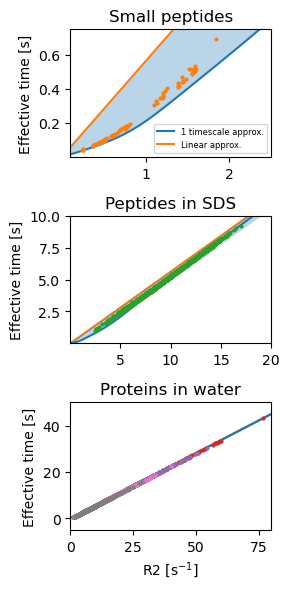

In [11]:
gammaH=267.513*10**6;
gammaN=-27.166*10**6;


fig, axs = plt.subplots(3, 1)

plt.rcParams["figure.figsize"] = [3, 6]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 10})
fig.patch.set_facecolor('xkcd:white')


x2=np.logspace((-12),(-7),100)
axs[0].plot(oneTime["R2"][1],oneTime["R2"][0]*10**9,"-",label="1 timescale approx.")
axs[1].plot(oneTime["R2"][1],oneTime["R2"][0]*10**9,"-")
axs[2].plot(oneTime["R2"][1],oneTime["R2"][0]*10**9,"-")


axs[0].fill(limits["R2"][1], limits["R2"][0]*10**9,  alpha=0.3)
axs[1].fill(limits["R2"][1], limits["R2"][0]*10**9,  alpha=0.3)
axs[2].fill(limits["R2"][1], limits["R2"][0]*10**9,  alpha=0.3)


axs[0].set_xlim(0.1,2.5)
axs[0].set_ylim(10**(-3),0.00075*10**(3))

axs[1].set_xlim(0.001,20)
axs[1].set_ylim(10**(-3),0.010*10**(3))


axs[2].set_xlim(-0.01,80)
axs[2].set_ylim(-5,0.050*10**(3))

#plt.suptitle(str(magn_field_MHz)+" MHz")

    




axs[0].plot(systems["small_peptides"][2],systems["small_peptides"][0],"o",c="C1", markersize=2)

axs[1].plot(systems["peptides_SDSmicelles"][2],systems["peptides_SDSmicelles"][0],"o",c="C2", markersize=2)
        
amanda=["Calmodulin",
       "CDNF",
       "EN2",
       "musMANF",
       "TonB"]
    
for i, system in enumerate(amanda):
    axs[2].plot(systems[system][2],systems[system][0],"o",c="C"+str(3+i), markersize=2)
  


axs[0].set_ylabel("Effective time [s]")
#axs[0].set_xlabel("T2 [s]")

axs[1].set_ylabel("Effective time [s]")
#axs[1].set_xlabel("T2 [s]")

axs[2].set_ylabel("Effective time [s]")
axs[2].set_xlabel("R2 [s$^{-1}$]")

axs[0].set_title("Small peptides")
axs[1].set_title("Peptides in SDS")
axs[2].set_title("Proteins in water")

wh = gammaH * magnetic_field 
wn = gammaN * magnetic_field 

T1, T2, NOE, x = getSRT(-20,-3,200,magnetic_field)

mu = 4 * np.pi * 10**(-7) #magnetic constant of vacuum permeability
h_planck = 1.055 * 10**(-34); #reduced Planck constant
rN = 0.101 * 10**(-9); # average cubic length of N-H bond
d = 1 * (mu * gammaN * gammaH * h_planck) / (4 * np.pi * rN**3); # dipolar coupling constant

K1=(d**2 / 20)
K2=(wn * 160 * 10**(-6))**2 / 45


eff_from_R2_approx=1/((4*K1+4*K2)*T2)*10**9



axs[0].plot(1/T2,eff_from_R2_approx,label="Linear approx.")
axs[1].plot(1/T2,eff_from_R2_approx,zorder=0)
axs[2].plot(1/T2,eff_from_R2_approx,zorder=0)

axs[0].legend(prop={"size":6})

#plt.title("Possible effective times for T1 measuraments at "+str(magn_field_MHz)+" MHZ")

plt.savefig("eff_vs_T2_details.pdf")